<a href="https://colab.research.google.com/github/ozgesengil/fMRI_Analysis_Scripts/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing the fMRI Data
As we discussed in class, there is a lot of noise in a typical fMRI dataset. In this notebook we focus on filtering the data in time and space domains. We will make use of Fourier transformation and filtering the data in the frequency domain.
##Temporal Filtering
Two sources of temporal noise are slow scanner drift and high-frequency noise. To simulate them and then to try to remove them, let's first simulate some BOLD response. Let's start with defining a double-gamma HIRF:

In [ ]:
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft

def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
  c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1)
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
  return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01)
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)))

def bold_response(n, h):
  return np.convolve(n,h)

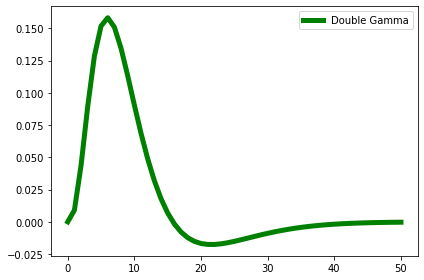

In [ ]:
#@title Double-gamma HIRF
time = np.arange(0, 51, 1.0)
# parameters for single and double gamma distribution functions
n1 = 4
lmbd1 = 2
t01 = 0
n2 = 7
lmbd2 = 3
t02 = 0
a = 0.3
# Plot the normalized sum of two gamma dist. functions
bold_double_gamma = hrf_double_gamma(time, n1, n2, lmbd1, lmbd2, t01, t02, a)
plt.plot(time, bold_double_gamma,
         color = 'green', linewidth = 5, label="Double Gamma")
plt.legend()
plt.tight_layout()
plt.show()


Next, let's assume neuronal responses as a train of boxcars

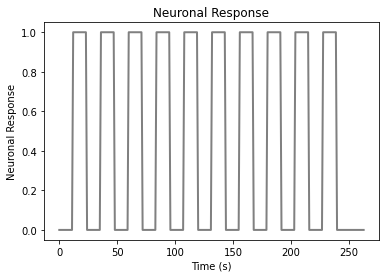

In [ ]:
#@title A boxcar neuronal response

onset = 12 #@param {type:"integer"}
active_duration =  12#@param {type:"integer"}
rest_duration =  12#@param {type:"integer"}
block_duration = active_duration+rest_duration
number_of_blocks = 10 #@param {type:"integer"}
final_rest = 12 #@param {type:"integer"}
box = np.zeros(onset + block_duration*number_of_blocks+final_rest)
block_start = np.arange(onset, number_of_blocks*block_duration, block_duration)
for start in block_start:
  box[start:start+active_duration] = np.ones(active_duration)
box[box.size-final_rest:box.size] = np.zeros(final_rest)

plt.plot(box, color='gray', linestyle='solid', linewidth=2)
plt.title("Neuronal Response")
plt.xlabel("Time (s)")
plt.ylabel("Neuronal Response")
plt.show()

Finally, let's convolve the neuronal response and the HIRF. We can add unstructured noise (additve, normal) and scanner dirrift here.

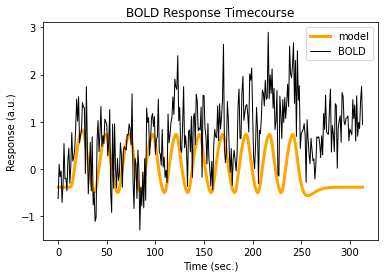

In [ ]:
#@title Simulated BOLD response

h = bold_double_gamma
bold = bold_response(box, h)
bold -= np.mean(bold) #center at mean=0

model = np.array(np.arange(0,bold.size),dtype=float)
model[0:bold.size] = bold[0:bold.size]

bold_noise = True #@param {type:"boolean"}
if(bold_noise):
  bold_noise_level =  0.5#@param {type:"raw"}
  bold += norm.rvs(scale=bold_noise_level, size=bold.size)

scanner_drift = True #@param {type:"boolean"}
if(scanner_drift):
  linear_drift =  0.005#@param {type:"raw"}
  A_periodic_drift =  0.2#@param {type:"raw"}
  f_periodic_drift =  0.01#@param {type:"raw"}
  bold += (np.arange(0,bold.size)*linear_drift
           + A_periodic_drift*np.sin(f_periodic_drift*np.arange(0,bold.size)*2*np.pi))

t = np.arange(0, box.size+50, 1)
plt.plot(t, model[0:t.size], color='orange', linestyle='solid', linewidth=3, label='model')
plt.plot(t, bold[0:t.size], color='black', linestyle='solid', linewidth=1, label='BOLD')
plt.title('BOLD Response Timecourse')
plt.xlabel('Time (sec.)')
plt.ylabel('Response (a.u.)')
plt.legend()
plt.show()

Can we remove these noises using Fourier transform? Let's try! First use high- and low-pass filters (one by one, and then together) and observe what happens to the power spectrum.

158
158


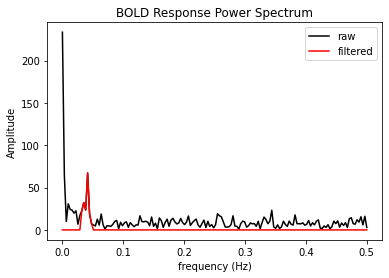

In [ ]:
fbold = fft.rfft(bold)
frequency = np.fft.rfftfreq(bold.size, d=1)

print(fbold.size)
print(frequency.size)

plt.plot(frequency, np.abs(fbold), color='black', label='raw')
plt.title('BOLD Response Power Spectrum')
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude')

is_high_pass_filter = True #@param {type:"boolean"}
high_pass_cutoff = 0.03 #@param {type:"raw"}

if(is_high_pass_filter):
  fbold[np.where(frequency<high_pass_cutoff)] = 0

is_low_pass_filter = True #@param {type:"boolean"}
low_pass_cutoff = 0.05 #@param {type:"raw"}

if(is_low_pass_filter):
  fbold[np.where(frequency>low_pass_cutoff)] = 0

if(is_high_pass_filter or is_low_pass_filter):
  plt.plot(frequency, np.abs(fbold), color='red', label='filtered')

plt.legend()
plt.show()





Next, using the components retained after the filter above, let's do an inverse FFT and see how the timecourse looks like

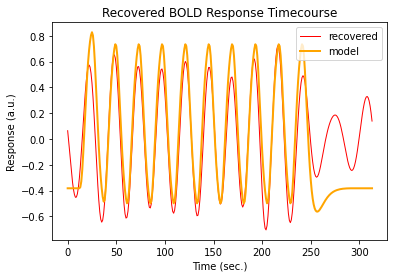

In [ ]:
bold_recovered = fft.irfft(fbold)
plt.plot(bold_recovered, color='red', linestyle='solid', linewidth=1, label='recovered')
plt.plot(t, model[0:t.size], color='orange', linestyle='solid', linewidth=2, label='model')
#plt.plot(t, bold[0:t.size], color='black', linestyle='solid', linewidth=1, label='BOLD')
plt.title('Recovered BOLD Response Timecourse')
plt.xlabel('Time (sec.)')
plt.ylabel('Response (a.u.)')
plt.legend()
plt.show()

##Spatial Filtering
The other filtering operation we can use is in the space domain. This is useful especially in group studies. But usually not needed for ROI-based analyses and MVPA. First Let's create some data (1-dimensional)

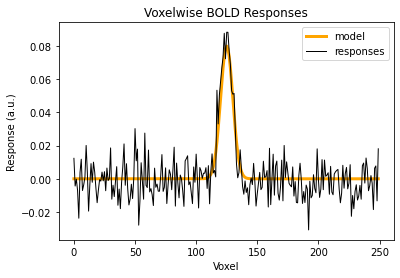

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy.fft as fft

# neural response, n:
nVoxels = 250
voxels =  np.arange(0,nVoxels)
mean = nVoxels/2
model_sigma = 5.0
amplitude = 1
model = amplitude * norm.pdf(voxels,mean,scale=model_sigma)
plt.title('Voxelwise BOLD Responses')
plt.xlabel('Voxel')
plt.ylabel('Response (a.u.)')
plt.plot(model, color='orange', linestyle='solid', linewidth=3, label='model')
noise_sigma = 0.01 #@param {type:'raw'}
responses = model + norm.rvs(scale=noise_sigma, size=model.size)
plt.plot(responses, color='black', linestyle='solid', linewidth=1, label='responses')
plt.legend()
plt.show()

Let's look at the Fourier Transform of this & apply low-pass filter (i.e. remove high-frequency noise)

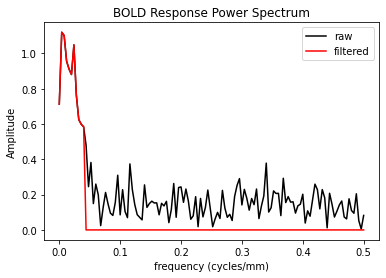

In [ ]:
fResponses = fft.rfft(responses)
freq = np.fft.rfftfreq(responses.size, d=1)
plt.title('BOLD Response Power Spectrum')
plt.xlabel('frequency (cycles/mm)')
plt.ylabel('Amplitude')
plt.plot(freq, np.abs(fResponses), color='black', label='raw')

is_low_pass_filter = True #@param {type:'boolean'}
low_cutoff = 0.04 #@param {type:'raw'}
if(is_low_pass_filter):
  fResponses[np.where(freq>low_cutoff)] = 0
  plt.plot(freq, np.abs(fResponses), color='red', label='filtered')
plt.legend()

plt.show()

Now let's look at the recovered response

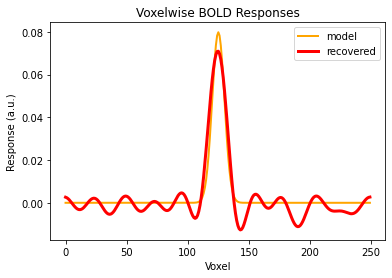

In [ ]:
responses_recovered = fft.irfft(fResponses)
plt.plot(voxels, model, color='orange', linestyle='solid', linewidth=2, label='model')
plt.plot(voxels, responses_recovered, color='red', linestyle='solid', linewidth=3, label='recovered')
plt.title('Voxelwise BOLD Responses')
plt.xlabel('Voxel')
plt.ylabel('Response (a.u.)')
plt.legend()
plt.show()

We did the filtering using FFT above. One can, however, do the same low-pass filtering simply by convolving the response with a Gaussian kernel. Using the convolution theorem, it is possible to show that the two operations are identical. So, here let's do the filtering with a convolution. This is the kernel definition

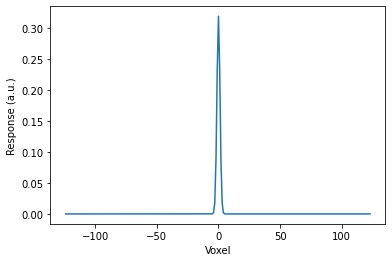

In [ ]:
#@title Kernel Definition

fSigma = 0.25*model_sigma #@param {type:'raw'}
kernelLimits = np.arange(-nVoxels/2+1,nVoxels/2-1)
kernel = norm.pdf(kernelLimits, scale = fSigma)
plt.plot(kernelLimits,kernel)
plt.xlabel('Voxel')
plt.ylabel('Response (a.u.)')
plt.show()

This is the result of convolution. How does it look?

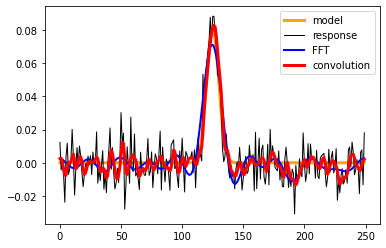

In [ ]:
#@title Convolution results
responses_recovered_convolution = np.convolve(responses, kernel,mode='same')
plt.plot(voxels, model, color='orange',linestyle='solid', linewidth=3,
         label='model')
plt.plot(voxels, responses, color='black',linestyle='solid', linewidth=1,
         label='response')
plt.plot(voxels, responses_recovered, color='blue', linestyle='solid',
         linewidth=2, label='FFT')
plt.plot(voxels, responses_recovered_convolution, color='red',
         linestyle='solid', linewidth=3, label='convolution')
plt.legend()
plt.legend()
plt.show()

Things to do:


*   Show convolution with a Gaussian kernel is equivalent to low-pass filtering: fft of the gaussian; multiply with fft of response etc.
*   Optimize the code and write notes: use the dedicated low-pass and high-pass filters in scipy, e.g. butter, lfilter, freqz

